# Kiva Crowd-Funding Data Analysis

In [233]:
from narcos.kiva_data import KivaData
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', 
    {
        'grid.color': '.8',
        'labelsize': 'large',
    })
sns.set(font_scale = 1.5)
kiva_data = KivaData(use_sample=True)
df = kiva_data.loan_data

## Histogram

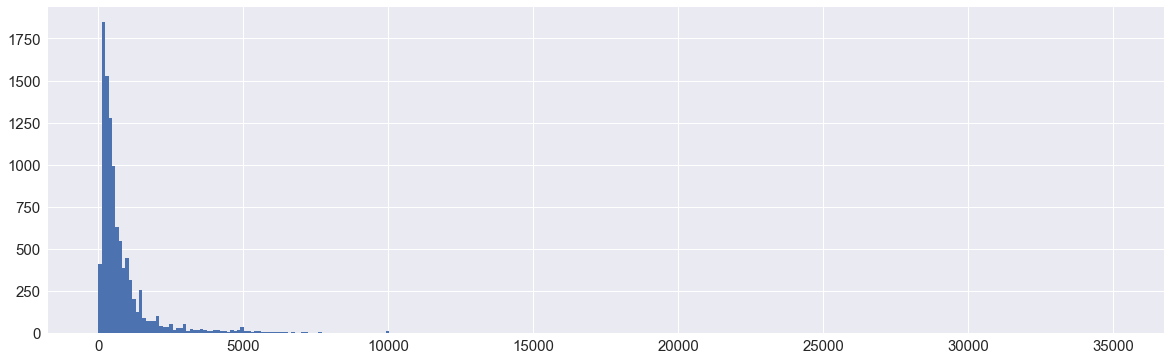

In [235]:
figure, ax = plt.subplots(figsize=(20,6))
df.reset_index()['funded_amount'].hist(
    bins=300,
    ax=ax
)
plt.show()

## Boxplot

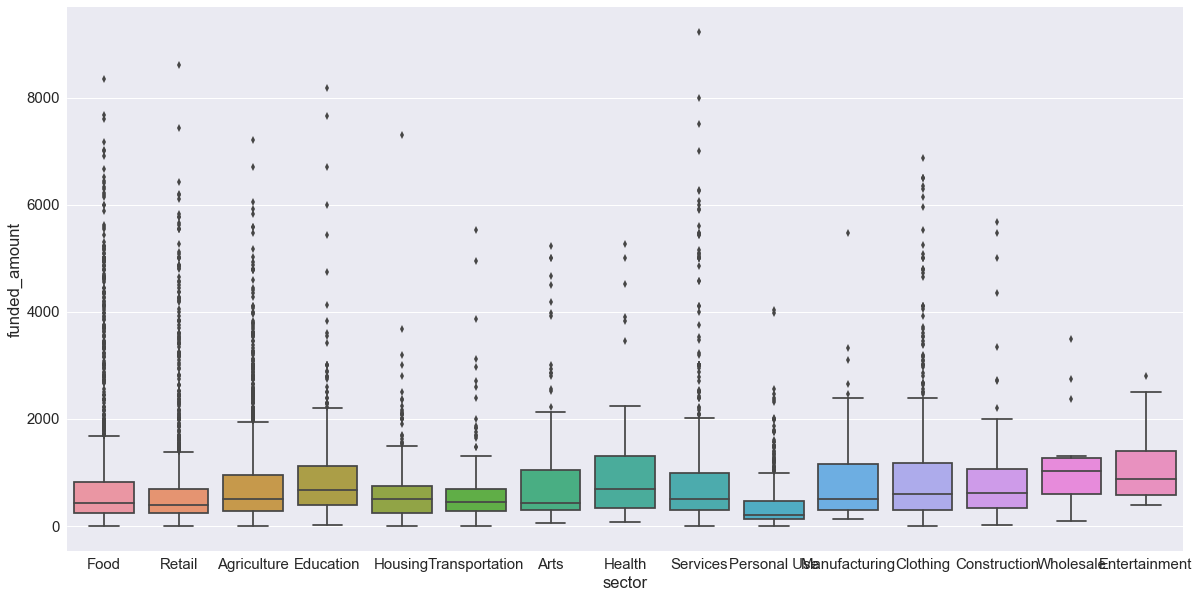

In [236]:
figure, ax = plt.subplots(figsize=(20,10))

sns.boxplot(
    x='sector', 
    y='funded_amount',
    #orient="h",
    data=df[df['funded_amount'] < 10000])
plt.show()

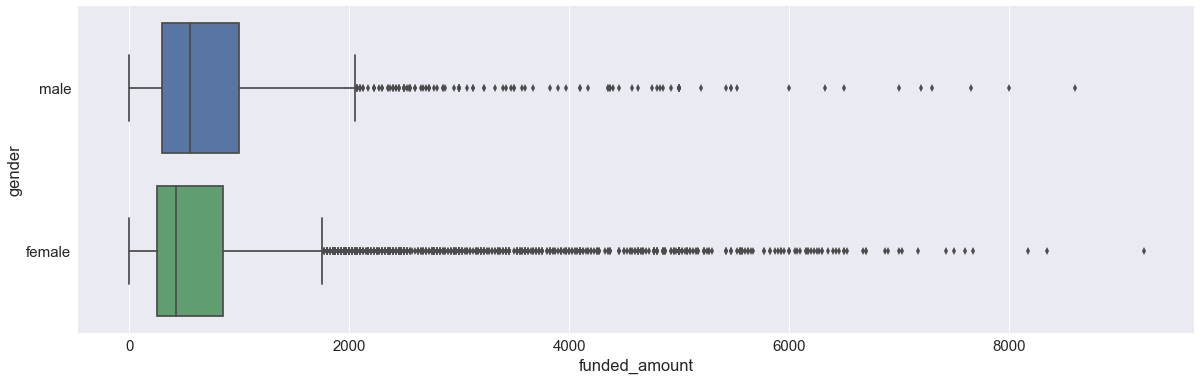

In [237]:
figure, ax = plt.subplots(figsize=(20,6))

sns.boxplot(
    y='gender', 
    x='funded_amount', 
    orient='h',
    data=df[df['funded_amount'] < 10000])
plt.show()

In [238]:
## Number loans ranked by country

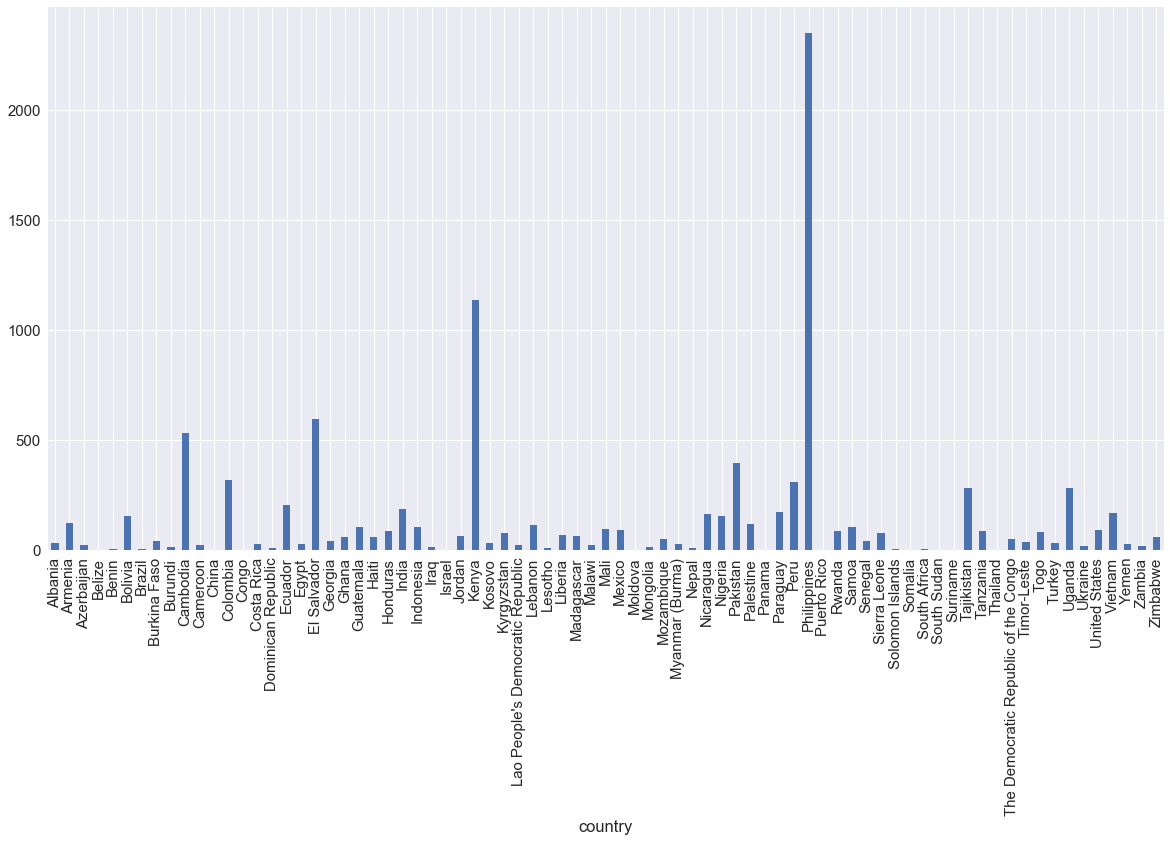

In [239]:
figure, ax = plt.subplots(figsize=(20,10))
df.groupby('country')['funded_amount'].count().plot.bar()
plt.show()

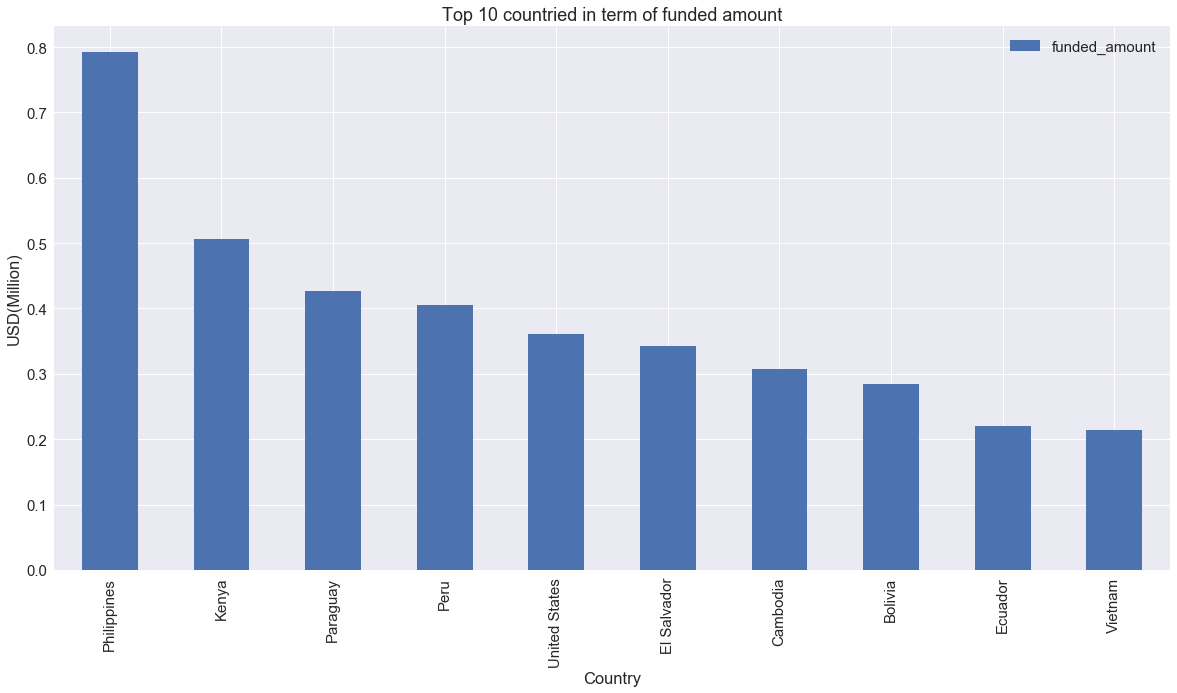

In [240]:
figure, ax = plt.subplots(figsize=(20,10))
( df.groupby('country')[['funded_amount']].sum() / (1000 * 1000 ) ).sort_values(
    by='funded_amount', ascending=False).head(10).plot.bar(
    ax=ax,
)
plt.xlabel('Country')
plt.ylabel('USD(Million)')
plt.title('Top 10 countried in term of funded amount')
plt.show()

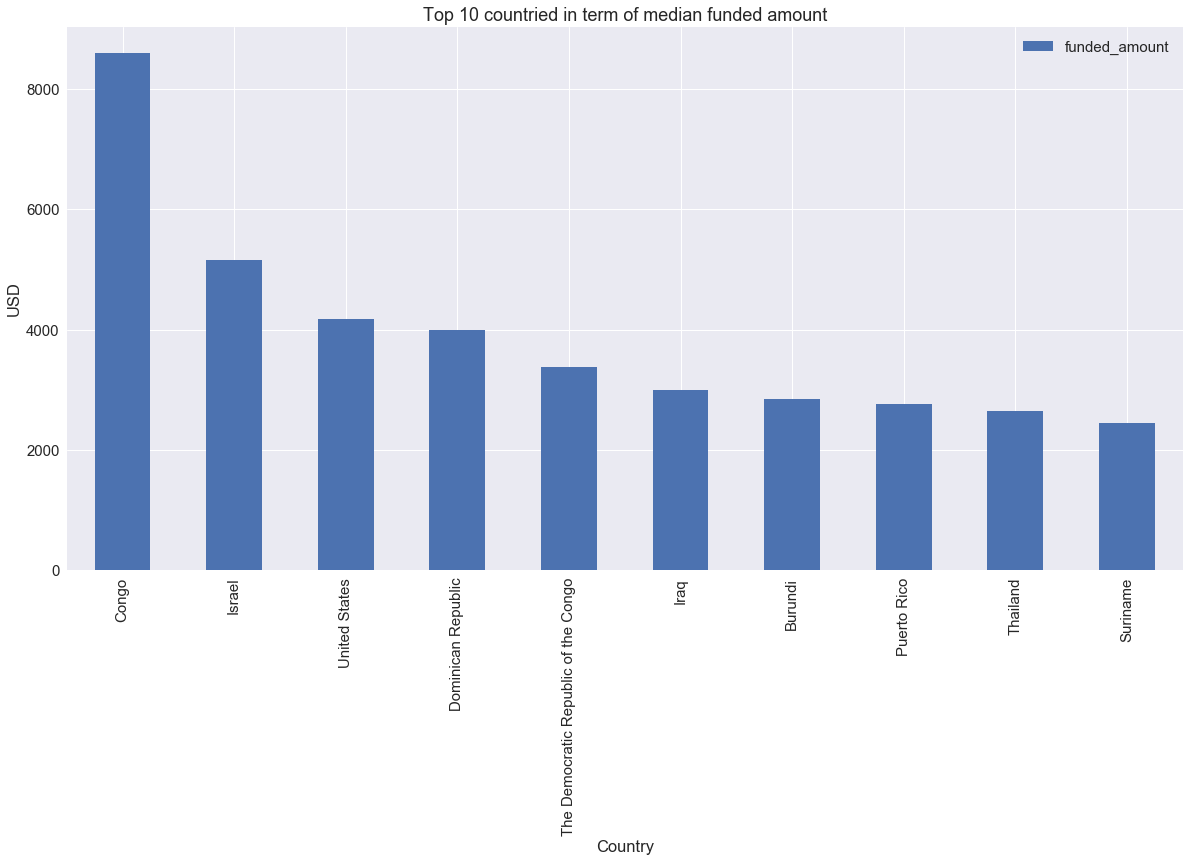

In [241]:
figure, ax = plt.subplots(figsize=(20,10))
( df.groupby('country')[['funded_amount']].median() ).sort_values(
    by='funded_amount', ascending=False).head(10).plot.bar(
    ax=ax,
)
plt.xlabel('Country')
plt.ylabel('USD')
plt.title('Top 10 countried in term of median funded amount')
plt.show()

## GDP vs Median Funded Amount

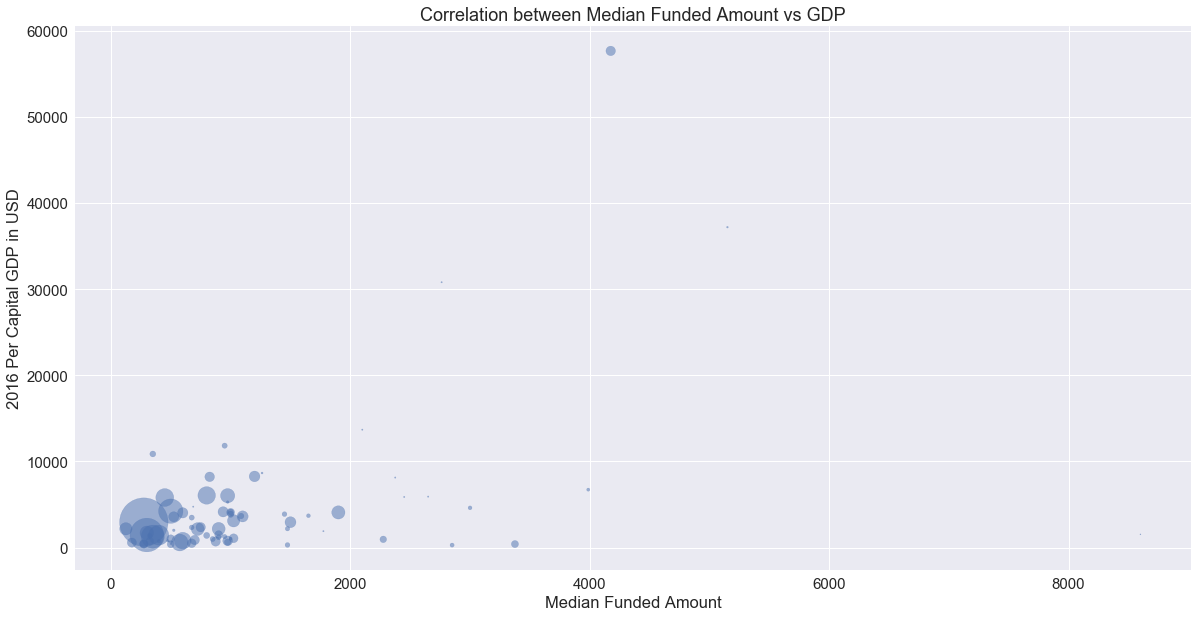

In [242]:
import wbdata
import numpy as np
import pandas as pd
gdp_lookup = {}
for country_code in df.country_code.unique():
    gdp_lookup[country_code] = wbdata.get_data("NY.GDP.PCAP.CD", country=(country_code))[1]['value']

median_by_country = df.groupby('country_code')[['funded_amount']].median()
median_by_country
for country_code in median_by_country.index:
    median_by_country.loc[country_code, 'gdp'] = pd.to_numeric(gdp_lookup[country_code])

count_by_country = df.groupby('country_code')[['funded_amount']].count().rename(
    columns={'funded_amount': 'loan_count'}
)
median_by_country = median_by_country.join(count_by_country)

figure, ax = plt.subplots(figsize=(20,10))
median_by_country.plot.scatter(
    x='funded_amount',
    y = 'gdp',
    s = median_by_country['loan_count'],
    ax=ax,
    alpha=0.5,
)

plt.xlabel('Median Funded Amount')
plt.ylabel('2016 Per Capital GDP in USD')
plt.title('Correlation between Median Funded Amount vs GDP')
plt.show()

### Narrow down to GDP < 20000, and Median Funded Amount < 4000

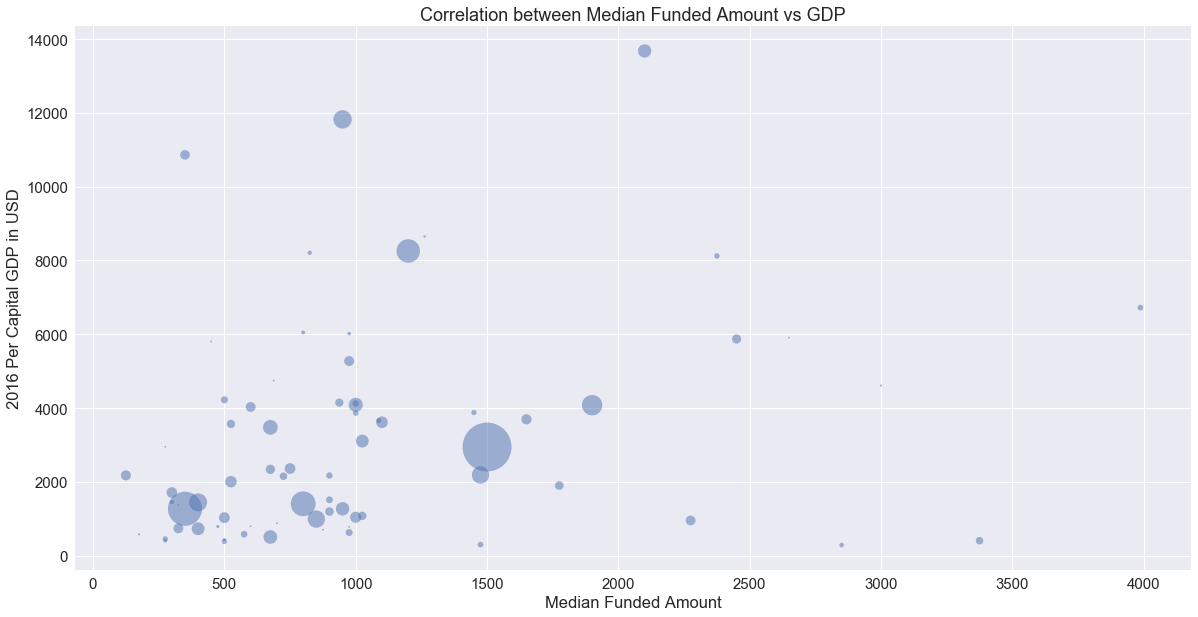

In [243]:
figure, ax = plt.subplots(figsize=(20,10))
median_by_country.query(
    'gdp < 20000 & funded_amount < 4000'
).plot.scatter(
    x='funded_amount',
    y = 'gdp',
    s = median_by_country['loan_count'],
    ax=ax,
    alpha=0.5,
)

plt.xlabel('Median Funded Amount')
plt.ylabel('2016 Per Capital GDP in USD')
plt.title('Correlation between Median Funded Amount vs GDP')
plt.show()

## Gender

In [281]:

median_by_country = df.groupby(['country_code', 'gender'])[['funded_amount']].median().reset_index()

median_by_country.loc[:, 'gdp'] = median_by_country['country_code'].map(
    lambda x: pd.to_numeric(gdp_lookup[x])
)

In [282]:
median_by_country = median_by_country.set_index(['country_code', 'gender'])


In [283]:
count_by_country = df.groupby(['country_code', 'gender'])[['funded_amount']].count().rename(
    columns={'funded_amount': 'loan_count'}
)
median_by_country = median_by_country.join(count_by_country).reset_index()

In [284]:
median_by_country.head()

,country_code,gender,funded_amount,gdp,loan_count
0,AL,female,1000.0,4124.982390,21
1,AL,male,1000.0,4124.982390,14
2,AM,female,1425.0,3614.688357,77
3,AM,male,850.0,3614.688357,47
4,AZ,female,1600.0,3878.709257,10


In [285]:
median_by_country[
    median_by_country['gender'] == 'male'
].head()

,country_code,gender,funded_amount,gdp,loan_count
1,AL,male,1000.0,4124.982390,14
3,AM,male,850.0,3614.688357,47
5,AZ,male,1250.0,3878.709257,13
7,BF,male,975.0,627.103079,13
9,BI,male,3125.0,285.727442,4


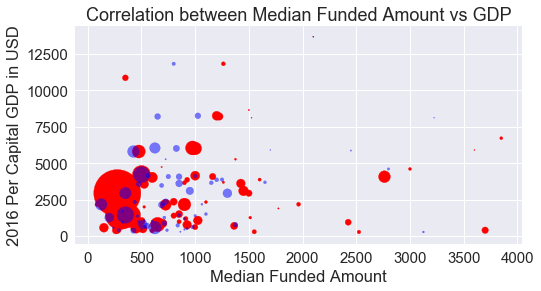

In [288]:
figure, ax = plt.subplots(figsize=(8,4))

median_by_country = median_by_country.query('gdp < 20000 & funded_amount < 4000')
female_df = median_by_country[
    median_by_country['gender'] == 'female'
]

female_df.plot.scatter(
    x='funded_amount',
    y='gdp',
    color='red',
    s = female_df['loan_count'],
    ax=ax
)

male_df = median_by_country[
    median_by_country['gender'] == 'male'
]

male_df.plot.scatter(
    x='funded_amount',
    y='gdp',
    color='blue',
    s = male_df['loan_count'],
    ax=ax,
    alpha=0.5
)

plt.xlabel('Median Funded Amount')
plt.ylabel('2016 Per Capital GDP in USD')
plt.title('Correlation between Median Funded Amount vs GDP')
plt.show()

### Narrow down to GDP < 20000, and Median Funded Amount < 4000

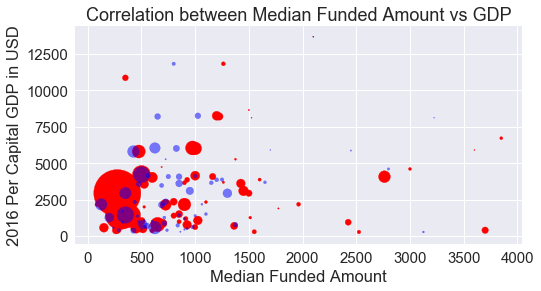

In [289]:
figure, ax = plt.subplots(figsize=(8,4))

female_df = median_by_country[
    median_by_country['gender'] == 'female'
]

female_df.plot.scatter(
    x='funded_amount',
    y='gdp',
    color='red',
    s = female_df['loan_count'],
    ax=ax
)

male_df = median_by_country[
    median_by_country['gender'] == 'male'
]

male_df.plot.scatter(
    x='funded_amount',
    y='gdp',
    color='blue',
    s = male_df['loan_count'],
    ax=ax,
    alpha=0.5
)

plt.xlabel('Median Funded Amount')
plt.ylabel('2016 Per Capital GDP in USD')
plt.title('Correlation between Median Funded Amount vs GDP')
plt.show()